<h1 align=center>IBM Applied Data Science</h1>

<h2 align=center>Capstone Project - The Battle of the Neighborhoods</h2>

## Introduction
We have been approached by our client to research possible locations in London for their new organic coffee and juice café. They currently have one café located near <b>Hackney Central station</b> which has proved very successful, so they are looking to open a second café located in or near a London station where the new location matches their current cafés location in relation to the amount of people who pass through the station each day and the makeup of the neighborhood surrounding the station.

## 1. Load Libraries

In [1]:
#Install Beautifulsoup 
!conda install -c anaconda beautifulsoup4
from bs4 import BeautifulSoup

import numpy as np

import pandas as pd

from geopy.geocoders import Nominatim # Convert address into lat/long values
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print("Imports complete.")

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.9.0       |           py36_0         165 KB  anaconda
    certifi-2020.4.5.1         |           py36_0         159 KB  anaconda
    ca-certificates-2020.1.1   |                0         132 KB  anaconda
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    ------------------------------------------------------------
                                           Total:         4.2 MB

The following packages will be UPDATED:

    beautifulsoup4:  4.7.1-py36_1      --> 4.9.0-py36_0      anaconda
    ca-certificates: 2020.1.1-0        --> 2020.1.1-0        anaconda
    certifi:         2020.4.5.1-py36_0 --> 2020.4.5.1-py36_0 anaconda
    openssl:         1.1.1g-

## 2. Download and prepare data.
Using the Beautifulsoup package scrape the Wikipedia page <b>List of London Railway stations</b> (https://en.wikipedia.org/wiki/List_of_London_railway_stations) to get the full list stations along with the lat/long location.

Import only the <b>Station Name, Fare Zone, Category and Cooridnate</b> fields from the webpage into a pandas dataframe.

During the import the Coordinates field is split to store the Lat/Long values as seperate fields in the dataframe.

In [2]:
#Request webpage
source = requests.get('https://en.wikipedia.org/wiki/List_of_London_railway_stations').text

#Parse webpage into beautifulsoup object
soup = BeautifulSoup(source,'html.parser')

#Find the table of interest and read it into a dataframe
table = soup.find("table",{"class":"wikitable sortable"})

table_rows = table.find_all('tr')
stn_list=[]
for tr in table_rows:
    td = tr.find_all('td')
    stn_row=[]
    
    count = 0
    for tr in td:
        if count == 0:   #Get Station Name
            stn_row.append(tr.find('a').text.strip())
        if count == 4:   #Get Fare Zone
            stn_row.append(tr.text.strip())
        if count == 6:   #Get Station Category
            stn_row.append(tr.text.strip())
        if count == 7:   #Get Station Lat / Long
            coord = tr.find('span',{"class":"geo"}).text.strip()   
            stn_row.append(float(coord.split(";")[0]))  #Get lat 
            stn_row.append(float(coord.split(";")[1]))  #Get long
            
        count = count + 1
    
    #Ignore the first row as it contains the table headers so returns an empty list
    if len(stn_row) !=0:
        stn_list.append(stn_row)

        
# Create a dataframe from the station list
df_all_stn = pd.DataFrame(stn_list,columns=["Station","FareZone","Category","lat","lng"])
df_all_stn.head(10)

Station FareZone  Category      lat     lng
0        Abbey Wood        4         C  51.4915  0.1229
1     Acton Central        3         D  51.5088 -0.2634
2   Acton Main Line        3         E  51.5169 -0.2669
3       Albany Park        5         D  51.4358  0.1266
4  Alexandra Palace        3         D  51.5983 -0.1197
5          Amersham        9  unlisted  51.6747 -0.6088
6           Anerley        4         E  51.4125 -0.0651
7            Balham        3         C  51.4426 -0.1520
8          Banstead        6         F  51.3292 -0.2132
9           Barking        4         B  51.5393  0.0817

## 3. Get the London stations that meet the clients requirements and display locations on a Map.

The customer wants to locate their new cafe in the suburbs that are nearest to central London, they don't want premises in central London due to the high cost of rent. To meet this requirement we are only looking at stations that fall into <b>Fare Zone 2</b>.

The station must still have high through put of passengers even if it's not located in Central London. To meet his requirement we will only be looking at stations that fall into <b>Category B, C or D</b>.

The categories are based on the following <b>Trips Per Annum values</b>, further information can be found at https://en.wikipedia.org/wiki/United_Kingdom_railway_station_categories  
<br>Catergory <b>B = Over 2 million</b> trips per annum.</br>
<br>Catergory <b>C = 0.5 to 2 million</b> trips per annum.</br>
<br>Catergory <b>D = 0.25 to 0.5 million</b> trips per annum.</br>

In [22]:
farezones = ['2']
stn_category = ['B','C','D']

df_stns = df_all_stn[(df_all_stn['FareZone'].isin(farezones)) & (df_all_stn['Category'].isin(stn_category))]
df_stns

Station FareZone Category        lat       lng
13         Battersea Park        2        D  51.477900 -0.147700
33               Brockley        2        D  51.464500 -0.036900
44            Camden Road        2        D  51.544400 -0.140100
72       Clapham Junction        2        B  51.464400 -0.170300
85      Dalston Kingsland        2        D  51.548200 -0.076300
87           Denmark Hill        2        D  51.468300 -0.089400
117         Finsbury Park        2        C  51.564653 -0.106366
125            Gospel Oak        2        D  51.555200 -0.151400
133       Hackney Central        2        D  51.547000 -0.055900
134         Hackney Downs        2        C  51.548300 -0.060100
138       Hampstead Heath        2        D  51.555300 -0.165400
173  Kensington (Olympia)        2        C  51.498500 -0.211000
214             New Cross        2        C  51.476000 -0.032500
215        New Cross Gate        2        C  51.475200 -0.040600
234           Peckham Rye        2        D  51.470100 -0.069100
244          Queen's Park        2        C  51.534100 -0.205300
269       Shepherd's Bush        2        D  51.505100 -0.217500
331       Wandsworth Town        2        C  51.461000 -0.187900
348        West Hampstead        2        D  51.547300 -0.191300

Get lat/long location for London so we can centre the map on this location.

In [23]:
address = 'London'
geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
lat = location.latitude
long = location.longitude
print('The Geographical location of ' + address  + ' are {}, {}'.format(lat, long))

The Geographical location of London are 51.5073219, -0.1276474


Display map centered on London and display the stations which meet the selection criteria.

In [24]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[lat, long], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_stns['lat'], df_stns['lng'], df_stns['Station']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

## 4. Use the Foursquare API to get a list venues local to each shortlisted London station.

The search distance from each station will be set to 500m
<br>We will limit the number of venues returned to 100.</br>

In [25]:
# The code was removed by Watson Studio for sharing.

Create function <b>getNearbyVenues</b> to get the list of nearby venues for each shortlisted station.

In [37]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Distance',
                  'Venue Category']
    
    return(nearby_venues)



Run the getNearbyVenues function for each station.

In [38]:
LIMIT=100
london_stations_venues = getNearbyVenues(names=df_stns['Station'],
                                   latitudes=df_stns['lat'],
                                   longitudes=df_stns['lng']
                                   )

Battersea Park
Brockley
Camden Road
Clapham Junction
Dalston Kingsland
Denmark Hill
Finsbury Park
Gospel Oak
Hackney Central
Hackney Downs
Hampstead Heath
Kensington (Olympia)
New Cross
New Cross Gate
Peckham Rye
Queen's Park
Shepherd's Bush
Wandsworth Town
West Hampstead


Print the dataframe size and list the number of unique venue categorys for each station.

In [39]:
print(london_stations_venues.shape)
london_stations_venues.groupby('Station').count()

(877, 8)


Station Latitude  Station Longitude  Venue  \
Station                                                            
Battersea Park                      16                 16     16   
Brockley                            22                 22     22   
Camden Road                         59                 59     59   
Clapham Junction                    52                 52     52   
Dalston Kingsland                   75                 75     75   
Denmark Hill                        17                 17     17   
Finsbury Park                       57                 57     57   
Gospel Oak                          16                 16     16   
Hackney Central                     86                 86     86   
Hackney Downs                       65                 65     65   
Hampstead Heath                     43                 43     43   
Kensington (Olympia)                37                 37     37   
New Cross                           44                 44     44   
New Cross Gate                      38                 38     38   
Peckham Rye                         65                 65     65   
Queen's Park                        26                 26     26   
Shepherd's Bush                     73                 73     73   
Wandsworth Town                     34                 34     34   
West Hampstead                      52                 52     52   

                      Venue Latitude  Venue Longitude  Venue Distance  \
Station                                                                 
Battersea Park                    16               16              16   
Brockley                          22               22              22   
Camden Road                       59               59              59   
Clapham Junction                  52               52              52   
Dalston Kingsland                 75               75              75   
Denmark Hill                      17               17              17   
Finsbury Park                     57               57              57   
Gospel Oak                        16               16              16   
Hackney Central                   86               86              86   
Hackney Downs                     65               65              65   
Hampstead Heath                   43               43              43   
Kensington (Olympia)              37               37              37   
New Cross                         44               44              44   
New Cross Gate                    38               38              38   
Peckham Rye                       65               65              65   
Queen's Park                      26               26              26   
Shepherd's Bush                   73               73              73   
Wandsworth Town                   34               34              34   
West Hampstead                    52               52              52   

                      Venue Category  
Station                               
Battersea Park                    16  
Brockley                          22  
Camden Road                       59  
Clapham Junction                  52  
Dalston Kingsland                 75  
Denmark Hill                      17  
Finsbury Park                     57  
Gospel Oak                        16  
Hackney Central                   86  
Hackney Downs                     65  
Hampstead Heath                   43  
Kensington (Olympia)              37  
New Cross                         44  
New Cross Gate                    38  
Peckham Rye                       65  
Queen's Park                      26  
Shepherd's Bush                   73  
Wandsworth Town                   34  
West Hampstead                    52

In [40]:
print('There are {} uniques categories.'.format(len(london_stations_venues['Venue Category'].unique())))

There are 176 uniques categories.


## 5. Get the Top 10 venues for each station location so we can be begin to model neighborhoods surrounding each station.

Convert the categorial values in field Venue Category into 1's and 0's so they can be quantified.

In [41]:
# one hot encoding
london_onehot = pd.get_dummies(london_stations_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Station'] = london_stations_venues['Station'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot

Station  American Restaurant  Animal Shelter  Art Gallery  \
0          Battersea Park                    0               0            0   
1          Battersea Park                    0               0            0   
2          Battersea Park                    0               1            0   
3          Battersea Park                    0               0            0   
4          Battersea Park                    0               0            0   
5          Battersea Park                    0               0            0   
6          Battersea Park                    0               0            0   
7          Battersea Park                    0               0            0   
8          Battersea Park                    0               0            0   
9          Battersea Park                    0               0            0   
10         Battersea Park                    0               0            0   
11         Battersea Park                    0               0            0   
12         Battersea Park                    0               0            0   
13         Battersea Park                    0               0            0   
14         Battersea Park                    0               0            0   
15         Battersea Park                    0               0            0   
16               Brockley                    0               0            0   
17               Brockley                    0               0            0   
18               Brockley                    0               0            0   
19               Brockley                    0               0            0   
20               Brockley                    0               0            0   
21               Brockley                    0               0            0   
22               Brockley                    0               0            0   
23               Brockley                    0               0            0   
24               Brockley                    0               0            0   
25               Brockley                    0               0            0   
26               Brockley                    0               0            0   
27               Brockley                    0               0            0   
28               Brockley                    0               0            0   
29               Brockley                    0               0            0   
30               Brockley                    0               0            0   
31               Brockley                    0               0            0   
32               Brockley                    0               0            0   
33               Brockley                    0               0            0   
34               Brockley                    0               0            0   
35               Brockley                    0               0            0   
36               Brockley                    0               0            0   
37               Brockley                    0               0            0   
38            Camden Road                    0               0            0   
39            Camden Road                    0               0            0   
40            Camden Road                    0               0            0   
41            Camden Road                    0               0            0   
42            Camden Road                    0               0            0   
43            Camden Road                    0               0            0   
44            Camden Road                    0               0            0   
45            Camden Road                    0               0            0   
46            Camden Road                    0               0            0   
47            Camden Road                    0               0            0   
48            Camden Road                    0               0            0   
49            Camden Road                    0               0      

Group the data by Station location and get the mean value for each venue category for each location.

In [42]:
london_grouped = london_onehot.groupby('Station').mean().reset_index()
london_grouped

Station  American Restaurant  Animal Shelter  Art Gallery  \
0         Battersea Park             0.000000          0.0625     0.000000   
1               Brockley             0.000000          0.0000     0.000000   
2            Camden Road             0.000000          0.0000     0.000000   
3       Clapham Junction             0.000000          0.0000     0.000000   
4      Dalston Kingsland             0.013333          0.0000     0.000000   
5           Denmark Hill             0.000000          0.0000     0.000000   
6          Finsbury Park             0.000000          0.0000     0.000000   
7             Gospel Oak             0.000000          0.0000     0.000000   
8        Hackney Central             0.000000          0.0000     0.000000   
9          Hackney Downs             0.000000          0.0000     0.000000   
10       Hampstead Heath             0.023256          0.0000     0.000000   
11  Kensington (Olympia)             0.000000          0.0000     0.000000   
12             New Cross             0.000000          0.0000     0.022727   
13        New Cross Gate             0.000000          0.0000     0.000000   
14           Peckham Rye             0.000000          0.0000     0.015385   
15          Queen's Park             0.000000          0.0000     0.000000   
16       Shepherd's Bush             0.013699          0.0000     0.000000   
17       Wandsworth Town             0.000000          0.0000     0.000000   
18        West Hampstead             0.000000          0.0000     0.000000   

    Arts & Crafts Store  Asian Restaurant  BBQ Joint  Bagel Shop    Bakery  \
0              0.000000          0.000000   0.000000    0.000000  0.000000   
1              0.000000          0.000000   0.000000    0.000000  0.000000   
2              0.000000          0.016949   0.016949    0.000000  0.016949   
3              0.000000          0.019231   0.000000    0.000000  0.038462   
4              0.000000          0.000000   0.000000    0.000000  0.013333   
5              0.000000          0.000000   0.000000    0.000000  0.000000   
6              0.000000          0.017544   0.000000    0.017544  0.035088   
7              0.000000          0.000000   0.000000    0.000000  0.000000   
8              0.000000          0.000000   0.000000    0.000000  0.023256   
9              0.000000          0.000000   0.000000    0.000000  0.015385   
10             0.000000          0.000000   0.000000    0.000000  0.093023   
11             0.000000          0.000000   0.000000    0.000000  0.027027   
12             0.000000          0.000000   0.000000    0.000000  0.000000   
13             0.000000          0.000000   0.000000    0.000000  0.000000   
14             0.000000          0.000000   0.000000    0.000000  0.000000   
15             0.000000          0.000000   0.000000    0.000000  0.038462   
16             0.000000          0.000000   0.000000    0.013699  0.013699   
17             0.000000          0.000000   0.000000    0.000000  0.029412   
18             0.019231          0.000000   0.019231    0.019231  0.038462   

         Bar  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store    Bistro  \
0   0.187500         0.000000  0.000000     0.000000    0.000000  0.000000   
1   0.000000         0.000000  0.000000     0.000000    0.090909  0.000000   
2   0.000000         0.000000  0.016949     0.000000    0.016949  0.000000   
3   0.057692         0.000000  0.000000     0.000000    0.019231  0.000000   
4   0.026667         0.000000  0.013333     0.000000    0.000000  0.000000   
5   0.058824         0.000000  0.000000     0.000000    0.000000  0.000000   
6   0.000000         0.000000  0.000000     0.000000    0.000000  0.000000   
7   0.000000         0.000000  0.000000     0.000000    0.000000  0.000000   
8   0.011628         0.000000  0.000000     0.000000    0.000000  0.000000   
9   0.015385         0.000000  0.000000     0.000000    0.000000  0.000000   
10  0.000000         0.023256  0.0000

Create function <b>return_most_common_venues</b> and use it when iterating through the shortlist of station locations.

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
london_venues_sorted = pd.DataFrame(columns=columns)
london_venues_sorted['Station'] = london_grouped['Station']

for ind in np.arange(london_grouped.shape[0]):
    london_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

london_venues_sorted.head(30)



Station 1st Most Common Venue 2nd Most Common Venue  \
0         Battersea Park                   Bar                   Pub   
1               Brockley    Chinese Restaurant            Beer Store   
2            Camden Road                   Pub           Coffee Shop   
3       Clapham Junction                   Pub           Coffee Shop   
4      Dalston Kingsland                  Café         Grocery Store   
5           Denmark Hill           Coffee Shop                   Pub   
6          Finsbury Park                   Pub                  Café   
7             Gospel Oak                  Café           Coffee Shop   
8        Hackney Central                  Café                   Pub   
9          Hackney Downs                  Café                   Pub   
10       Hampstead Heath                  Café                   Pub   
11  Kensington (Olympia)                 Hotel                   Pub   
12             New Cross           Coffee Shop                  Café   
13        New Cross Gate                  Café                   Pub   
14           Peckham Rye                   Pub         Grocery Store   
15          Queen's Park           Coffee Shop           Yoga Studio   
16       Shepherd's Bush        Clothing Store                 Hotel   
17       Wandsworth Town                   Pub         Grocery Store   
18        West Hampstead           Coffee Shop         Grocery Store   

   3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
0                  Hotel         Train Station     Spanish Restaurant   
1            Coffee Shop             Gastropub          Grocery Store   
2                   Café    Italian Restaurant          Grocery Store   
3               Pharmacy         Grocery Store                    Bar   
4            Coffee Shop                   Pub            Pizza Place   
5                   Café         Deli / Bodega  Portuguese Restaurant   
6                  Hotel    Italian Restaurant            Pizza Place   
7                    Pub             Gastropub      Convenience Store   
8          Grocery Store          Cocktail Bar            Coffee Shop   
9          Grocery Store           Coffee Shop           Cocktail Bar   
10                Bakery           Coffee Shop      Indian Restaurant   
11         Grocery Store        Sandwich Place     Persian Restaurant   
12         Grocery Store                   Pub              Gastropub   
13         Grocery Store           Coffee Shop     Chinese Restaurant   
14    Italian Restaurant                  Café            Coffee Shop   
15                  Café  Gym / Fitness Center                    Gym   
16    Chinese Restaurant         Grocery Store       Sushi Restaurant   
17              Bus Stop  Gym / Fitness Center                  Hotel   
18           Pizza Place                   Pub                   Café   

   6th Most Common Venue   7th Most Common Venue 8th Most Common Venue  \
0     Chinese Restaurant  Furniture / Home Store    Italian Restaurant   
1      Fish & Chips Shop              Restaurant               Brewery   
2   Caribbean Restaurant             Supermarket              Pharmacy   
3            Supermarket                  Bakery          Cocktail Bar   
4             Restaurant            Cocktail Bar     Convenience Store   
5                    Bar           Train Station         Grocery Store   
6         Sandwich Place                Bus Stop           Coffee Shop   
7                   Farm                    Pool        Farmers Market   
8               Platform                 Brewery    Turkish Restaurant   
9         Breakfast Spot          Clothing Store        Sandwich Place   
10    Italian Restaurant                    Lake                Museum   
11           Coffee Shop       Convention Center     Indian Restaurant   
12   Indie Movie Theater              Restaurant    Chinese Restaurant   
13             Gastropub             Supermarket   Lebanese Restaurant   
14   

## 6. Cluster the neighborhoods around each of the shortlisted station locations, using the 10 most common venues for each location.

Use K-means to cluster the neighborhoods. The number of clusters will be set to 5.

In [33]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('Station', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]



array([2, 3, 3, 3, 3, 1, 3, 4, 3, 3], dtype=int32)

Create a new dataframe that includes the Cluster Label for each station location along with the top 10 venues.

In [36]:
# add clustering labels
#london_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = df_stns

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(london_venues_sorted.set_index('Station'), on='Station')

london_merged.head(50) # check the last columns!

Station FareZone Category        lat       lng  \
13         Battersea Park        2        D  51.477900 -0.147700   
33               Brockley        2        D  51.464500 -0.036900   
44            Camden Road        2        D  51.544400 -0.140100   
72       Clapham Junction        2        B  51.464400 -0.170300   
85      Dalston Kingsland        2        D  51.548200 -0.076300   
87           Denmark Hill        2        D  51.468300 -0.089400   
117         Finsbury Park        2        C  51.564653 -0.106366   
125            Gospel Oak        2        D  51.555200 -0.151400   
133       Hackney Central        2        D  51.547000 -0.055900   
134         Hackney Downs        2        C  51.548300 -0.060100   
138       Hampstead Heath        2        D  51.555300 -0.165400   
173  Kensington (Olympia)        2        C  51.498500 -0.211000   
214             New Cross        2        C  51.476000 -0.032500   
215        New Cross Gate        2        C  51.475200 -0.040600   
234           Peckham Rye        2        D  51.470100 -0.069100   
244          Queen's Park        2        C  51.534100 -0.205300   
269       Shepherd's Bush        2        D  51.505100 -0.217500   
331       Wandsworth Town        2        C  51.461000 -0.187900   
348        West Hampstead        2        D  51.547300 -0.191300   

     Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
13                2                   Bar                   Pub   
33                3    Chinese Restaurant            Beer Store   
44                3                   Pub           Coffee Shop   
72                3                   Pub           Coffee Shop   
85                3                  Café         Grocery Store   
87                1           Coffee Shop                   Pub   
117               3                   Pub                  Café   
125               4                  Café           Coffee Shop   
133               3                  Café                   Pub   
134               3                  Café                   Pub   
138               3                  Café                   Pub   
173               3                 Hotel                   Pub   
214               1           Coffee Shop                  Café   
215               1                  Café                   Pub   
234               3                   Pub         Grocery Store   
244               3           Coffee Shop           Yoga Studio   
269               3        Clothing Store                 Hotel   
331               0                   Pub         Grocery Store   
348               3           Coffee Shop         Grocery Store   

    3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
13                  Hotel         Train Station     Spanish Restaurant   
33            Coffee Shop             Gastropub          Grocery Store   
44                   Café    Italian Restaurant          Grocery Store   
72               Pharmacy         Grocery Store                    Bar   
85            Coffee Shop                   Pub            Pizza Place   
87                   Café         Deli / Bodega  Portuguese Restaurant   
117                 Hotel    Italian Restaurant            Pizza Place   
125                   Pub             Gastropub      Convenience Store   
133         Grocery Store          Cocktail Bar            Coffee Shop   
134         Grocery Store           Coffee Shop           Cocktail Bar   
138                Bakery           Coffee Shop      Indian Restaurant   
173         Grocery Store        Sandwich Place     Persian Restaurant   
214         Grocery Store                   Pub              Gastropub   
215         Grocery Store           Coffee Shop     Chinese Restaurant   
234    Italian Restaurant                  Café            Coffee Shop   
244                  Café  Gym / Fitness Center                    Gym   
269    Chinese Restaurant         Grocery Store       Sush

Get the Cluster Label for the cluster that our clients current cafe falls into (<b>Hackney Central Station</b>), so we can use that to get a list of the neighborhoods that fall into the same cluster type.

In [58]:
cluster_label = london_merged.loc[london_merged['Station'] == 'Hackney Central']['Cluster Labels'].values[0]
print('The Catergory label for Hackney Central = ' + str(cluster_label))

The Catergory label for Hackney Central = 3


Using the Cluster Label for Hackney Central, get a short-list of station locations that have a same Cluster Label.

We will also remove Hackney Central from the dataframe shortlist ready for further analysis.

In [59]:
df_stn_shortlist = london_merged.loc[(london_merged['Cluster Labels'] == cluster_label) & (london_merged['Station'] != 'Hackney Central')]
df_stn_shortlist

Station FareZone Category        lat       lng  \
33               Brockley        2        D  51.464500 -0.036900   
44            Camden Road        2        D  51.544400 -0.140100   
72       Clapham Junction        2        B  51.464400 -0.170300   
85      Dalston Kingsland        2        D  51.548200 -0.076300   
117         Finsbury Park        2        C  51.564653 -0.106366   
134         Hackney Downs        2        C  51.548300 -0.060100   
138       Hampstead Heath        2        D  51.555300 -0.165400   
173  Kensington (Olympia)        2        C  51.498500 -0.211000   
234           Peckham Rye        2        D  51.470100 -0.069100   
244          Queen's Park        2        C  51.534100 -0.205300   
269       Shepherd's Bush        2        D  51.505100 -0.217500   
348        West Hampstead        2        D  51.547300 -0.191300   

     Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
33                3    Chinese Restaurant            Beer Store   
44                3                   Pub           Coffee Shop   
72                3                   Pub           Coffee Shop   
85                3                  Café         Grocery Store   
117               3                   Pub                  Café   
134               3                  Café                   Pub   
138               3                  Café                   Pub   
173               3                 Hotel                   Pub   
234               3                   Pub         Grocery Store   
244               3           Coffee Shop           Yoga Studio   
269               3        Clothing Store                 Hotel   
348               3           Coffee Shop         Grocery Store   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
33            Coffee Shop             Gastropub         Grocery Store   
44                   Café    Italian Restaurant         Grocery Store   
72               Pharmacy         Grocery Store                   Bar   
85            Coffee Shop                   Pub           Pizza Place   
117                 Hotel    Italian Restaurant           Pizza Place   
134         Grocery Store           Coffee Shop          Cocktail Bar   
138                Bakery           Coffee Shop     Indian Restaurant   
173         Grocery Store        Sandwich Place    Persian Restaurant   
234    Italian Restaurant                  Café           Coffee Shop   
244                  Café  Gym / Fitness Center                   Gym   
269    Chinese Restaurant         Grocery Store      Sushi Restaurant   
348           Pizza Place                   Pub                  Café   

    6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
33      Fish & Chips Shop             Restaurant               Brewery   
44   Caribbean Restaurant            Supermarket              Pharmacy   
72            Supermarket                 Bakery          Cocktail Bar   
85             Restaurant           Cocktail Bar     Convenience Store   
117        Sandwich Place               Bus Stop           Coffee Shop   
134        Breakfast Spot         Clothing Store        Sandwich Place   
138    Italian Restaurant                   Lake                Museum   
173           Coffee Shop      Convention Center     Indian Restaurant   
234           Supermarket           Cocktail Bar                   Bar   
244                   Pub     Italian Restaurant                   Bar   
269        Cosmetics Shop            Supermarket                   Bar   
348     Indian Restaurant  Vietnamese Restaurant                Bakery   

             9th Most Common Venue 10th Most Common Venue  
33                             Pub      Convenience Store  
44   Paper / Office Supplies Store         Sandwich Place  
72                  Sandwich Place      Korean Restaurant  
85            Caribbean Restaurant            Yoga Studio  
117                         Bakery          Groc

## 7. Analyse the station shortlist - check how many other cafes/coffee shops are located around each station.

Create a dataframe to just include the shortlisted stations and only venues which are cafes or coffee shops.

In [51]:
venue_cat = ['Café','Coffee Shop']
stations = df_stn_shortlist['Station'].tolist()

stn_sl = london_stations_venues.loc[(london_stations_venues['Station'].isin(stations)) & (london_stations_venues['Venue Category'].isin(venue_cat))]
stn_sl

Station  Station Latitude  Station Longitude  \
20               Brockley         51.464500          -0.036900   
24               Brockley         51.464500          -0.036900   
39            Camden Road         51.544400          -0.140100   
41            Camden Road         51.544400          -0.140100   
43            Camden Road         51.544400          -0.140100   
53            Camden Road         51.544400          -0.140100   
71            Camden Road         51.544400          -0.140100   
74            Camden Road         51.544400          -0.140100   
75            Camden Road         51.544400          -0.140100   
82            Camden Road         51.544400          -0.140100   
84            Camden Road         51.544400          -0.140100   
105      Clapham Junction         51.464400          -0.170300   
109      Clapham Junction         51.464400          -0.170300   
115      Clapham Junction         51.464400          -0.170300   
116      Clapham Junction         51.464400          -0.170300   
119      Clapham Junction         51.464400          -0.170300   
139      Clapham Junction         51.464400          -0.170300   
159     Dalston Kingsland         51.548200          -0.076300   
163     Dalston Kingsland         51.548200          -0.076300   
167     Dalston Kingsland         51.548200          -0.076300   
179     Dalston Kingsland         51.548200          -0.076300   
184     Dalston Kingsland         51.548200          -0.076300   
187     Dalston Kingsland         51.548200          -0.076300   
204     Dalston Kingsland         51.548200          -0.076300   
211     Dalston Kingsland         51.548200          -0.076300   
247         Finsbury Park         51.564653          -0.106366   
264         Finsbury Park         51.564653          -0.106366   
274         Finsbury Park         51.564653          -0.106366   
284         Finsbury Park         51.564653          -0.106366   
287         Finsbury Park         51.564653          -0.106366   
290         Finsbury Park         51.564653          -0.106366   
401         Hackney Downs         51.548300          -0.060100   
409         Hackney Downs         51.548300          -0.060100   
410         Hackney Downs         51.548300          -0.060100   
411         Hackney Downs         51.548300          -0.060100   
423         Hackney Downs         51.548300          -0.060100   
426         Hackney Downs         51.548300          -0.060100   
431         Hackney Downs         51.548300          -0.060100   
437         Hackney Downs         51.548300          -0.060100   
439         Hackney Downs         51.548300          -0.060100   
451         Hackney Downs         51.548300          -0.060100   
459         Hackney Downs         51.548300          -0.060100   
470       Hampstead Heath         51.555300          -0.165400   
477       Hampstead Heath         51.555300          -0.165400   
483       Hampstead Heath         51.555300          -0.165400   
492       Hampstead Heath         51.555300          -0.165400   
494       Hampstead Heath         51.555300          -0.165400   
496       Hampstead Heath         51.555300          -0.165400   
497       Hampstead Heath         51.555300          -0.165400   
499       Hampstead Heath         51.555300          -0.165400   
533  Kensington (Olympia)         51.498500          -0.211000   
537  Kensington (Olympia)         51.498500          -0.211000   
544  Kensington (Olympia)         51.498500          -0.211000   
665           Peckham Rye         51.470100          -0.069100   
671           Peckham Rye         51.470100          -0.069100   
673           Peckham Rye         51.470100          -0.069100   
682           Peckham Rye         51.470100          -0.069100   
689           Peckham Rye         51.470100          -0.069100   
700          Queen's Park         51.534100          -0.205300   
701          Queen's Park         51.534100          -0.20

Get a count of the cafes and coffee shops at each shortlisted station location.

In [60]:
# one hot encoding
stn_sl_onehot = pd.get_dummies(stn_sl[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
stn_sl_onehot['Station'] = stn_sl['Station'] 

# move neighborhood column to the first column
fixed_columns = [stn_sl_onehot.columns[-1]] + list(stn_sl_onehot.columns[:-1])
stn_sl_onehot = stn_sl_onehot[fixed_columns]

stn_sl_onehot

stn_sl_grouped = stn_sl_onehot.groupby('Station').sum()[['Café','Coffee Shop']].reset_index()
stn_sl_grouped

Station  Café  Coffee Shop
0               Brockley     0            2
1            Camden Road     4            5
2       Clapham Junction     1            5
3      Dalston Kingsland     4            4
4          Finsbury Park     4            2
5          Hackney Downs     7            4
6        Hampstead Heath     6            2
7   Kensington (Olympia)     1            2
8            Peckham Rye     3            2
9           Queen's Park     2            3
10       Shepherd's Bush     2            0
11        West Hampstead     2            6

Display a bar chart showing the cumulative total of cafes/coffee shops at each station location.

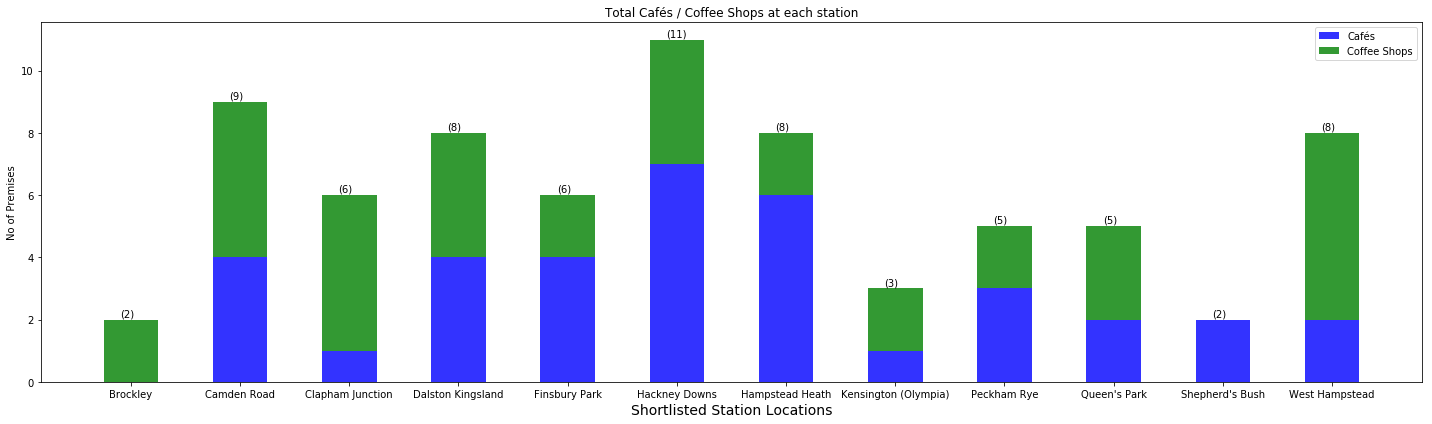

In [56]:
import matplotlib.pyplot as plt

n_groups = len(stn_sl_grouped.index)

#create plot
fig, ax = plt.subplots(figsize=(20,6))

index = np.arange(n_groups)
bar_width = 0.50
opacity = 0.8

cafes = stn_sl_grouped['Café']
coffee = stn_sl_grouped['Coffee Shop']

rects1 = plt.bar(index, cafes, bar_width, alpha=opacity, color='b', label='Cafés')
rects2 = plt.bar(index, coffee, bar_width, bottom=cafes, alpha=opacity, color='g', label='Coffee Shops')

plt.xlabel('Shortlisted Station Locations', fontsize=14)
plt.ylabel('No of Premises')
plt.title('Total Cafés / Coffee Shops at each station')
plt.xticks(index, stn_sl_grouped['Station'])
plt.legend()

#Add annotation showing the cumulative total in brackets
i = 0
for rect in rects2:
    height = rect.get_height() + rects1[i].get_height()
    ax.annotate('(' + str(height) + ')',(rect.get_x() + 0.15,height + 0.1))
    i = i + 1
    
plt.tight_layout()
plt.show()

From the bar chart above we can see that <b>Brockley, Kensington (Olympia)</b> and <b>Shepherd's Bush</b> have the least amount Cafe's and Coffee shops (so potentially less competition) from our shortlist of station locations. Going forward we will look at those three locations on a separate maps to get an idea how close those cafes and coffee shops are to the railway station.

## 8. Create a map for each of the final 3 selected station locations.

Create a function to draw a map showing the local cafes/coffee shops around the stations.

In [119]:
from folium.features import DivIcon

def stn_map(stn_name, venue_cats, zoom_scale, txt_anchor, txt_size_html):

    # Get station location
    stn_loc =  df_stns.loc[df_stns['Station'] == stn_name]
    lat = stn_loc.iloc[0]['lat']
    lng = stn_loc.iloc[0]['lng']

    # create map
    map_venues = folium.Map(location=[lat, lng], zoom_start=zoom_scale)
    local_cafes = london_stations_venues.loc[(london_stations_venues['Station'] == stn_name) & (london_stations_venues['Venue Category'].isin(venue_cats))]

    # Print distance to each cafe
    for dist,venue in zip(local_cafes['Venue Distance'],local_cafes['Venue']):
        print('Distance from Station to ' + venue + ' = ' + str(dist) + 'm')

    stn_name = stn_name.replace("'","")  # remove apostrophes
    
    #Draw station location and add label
    folium.CircleMarker([lat, lng],radius=8,label=stn_name,color='red',fill=True,fill_color='#fc6563',fill_opacity=0.7,parse_html=False).add_to(map_venues)
    folium.Marker([lat, lng],icon=DivIcon(icon_size=(500,150),icon_anchor=(-20,20),html='<div style="font-size: 16pt">%s</div>' % stn_name,)).add_to(map_venues)
                                                                                               
    # add cafe locations and labels to map
    for lat, lng, label in zip(local_cafes['Venue Latitude'], local_cafes['Venue Longitude'], local_cafes['Venue']):
        plabel = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=6,
            popup=plabel,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_venues)  
    
        folium.Marker([lat, lng],icon=DivIcon(icon_size=(500,150),icon_anchor=txt_anchor,html=txt_size_html % label,)).add_to(map_venues)

    return(map_venues)

### Create Map for the Brockley location and print distance to each of the cafe's from the station.

In [126]:
map_brok = stn_map(stn_name="Brockley", venue_cats = ['Café','Coffee Shop'], zoom_scale=20, txt_anchor=(40,-10), txt_size_html='<div style="font-size: 8pt">%s</div>')
map_brok

Distance from Station to Browns Of Brockley = 30m
Distance from Station to The Broca = 9m


### Create Map for Kensington (Olympia) location and print distance to each of the coffee shop from the station.

In [127]:
map_ken = stn_map(stn_name="Kensington (Olympia)", venue_cats = ['Café','Coffee Shop'], zoom_scale=16, txt_anchor=(-10,10), txt_size_html='<div style="font-size: 12pt">%s</div>')
map_ken

Distance from Station to Fitaly = 381m
Distance from Station to Costa Coffee = 386m
Distance from Station to UMG Cafe = 420m


### Create Map for Sheherd's Bush location and print distance to each of the cafe's from the station.

In [128]:
map_shep = stn_map(stn_name="Shepherd's Bush", venue_cats = ['Café','Coffee Shop'], zoom_scale=16, txt_anchor=(-10,10), txt_size_html='<div style="font-size: 12pt">%s</div>')
map_shep

Distance from Station to Liz Cafe = 476m
Distance from Station to Zarathustra Cafe = 379m


# Conclusion

We will put forward to the client the <b>Brockley, Kensington (Olympia)</b> and <b>Shepherd's Bush</b> stations as possible locations for their new organic coffee and juice cafe.

All the locations match their current location (<b>Hackney Central</b>) in relation to the make up the neighborbood surrounding the stations, which was one of their requirements (<b>see section 6</b>).

In terms of through put of passengers, <b>Kensington (Olympia)</b> is classed as a category C station whereas <b>Brockley</b> and <b>Shepherd's Bush</b> are classified as category D (see <b>section 3</b> for station category definitions), so <b>Kensington (Olympia)</b> will see more passengers pass through, so potentially more customers, however it does have a Costa Coffee within 500m of the station so the clients new cafe will have stronger competition for those potential customers. <b>Brockley</b> has 2 smaller coffee shops but they are both very close to the station. <b>Shepherd's Bush</b> has only 2 smaller cafes within 500m of the station so there will be less competition for the potential customers passing through the station.